## Predict with Pre-trained Model
  
This notebook shows how to load a pre-trained model and to use this for predicting pitch-class estimates of an unknown audio file.

&copy; Christof Weiss and Geoffroy Peeters, Télécom Paris 2021

In [1]:
import os
import sys
basepath = os.path.abspath(os.path.dirname(os.path.dirname('.')))
sys.path.append(basepath)
import numpy as np, os, scipy, scipy.spatial, matplotlib.pyplot as plt, IPython.display as ipd
from numba import jit
import librosa
import libfmp.b, libfmp.c3, libfmp.c5
import pandas as pd, pickle, re
from numba import jit
import torch.utils.data
import torch.nn as nn
import libdl.data_preprocessing
from libdl.data_loaders import dataset_context, dataset_context_segm
from libdl.nn_models import basic_cnn_segm_sigmoid, basic_cnn_segm_blank_logsoftmax
from libdl.data_preprocessing import compute_hopsize_cqt, compute_hcqt, compute_efficient_hcqt, compute_annotation_array_nooverlap

### 1. Specify and load model

In [2]:
dir_models = os.path.join(basepath, 'models_pretrained')

# Set model parameters
num_octaves_inp = 6
num_output_bins, min_pitch = 72, 24
model_params = {'n_chan_input': 6,
                'n_chan_layers': [20,20,10,1],
                'n_ch_out': 2,
                'n_bins_in': num_octaves_inp*12*3,
                'n_bins_out': num_output_bins,
                'a_lrelu': 0.3,
                'p_dropout': 0.2
                }
mp = model_params


### Select model according to paper's experiments (uncomment as desired) ##############################


# Experiment 1 (Table 2) - Loss and Model variants ####################################################

# Strongly-aligned training (BCE loss):
# fn_model, model = 'exp112aS_traintest_schubert_aligned_pitch_nooverlap_segmmodel.pt', basic_cnn_segm_sigmoid(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])

# Separable CTC (SCTC) loss:
# fn_model, model = 'exp118b_traintest_schubert_sctcthreecomp_pitch.pt', basic_cnn_segm_logsoftmax(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], n_ch_out=3, n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])

# Non-Epsilon MCTC (MCTC:NE) loss:
# fn_model, model = 'exp118d_traintest_schubert_mctcnethreecomp_pitch.pt', basic_cnn_segm_blank_logsoftmax(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], n_ch_out=3, n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])

# MCTC with epsilon (MCTC:WE) loss:
# fn_model, model = 'exp118e_traintest_schubert_mctcwe_pitch.pt', basic_cnn_segm_logsoftmax(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], n_ch_out=mp['n_ch_out'], n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])



# Experiment 2 (Section 3.2) - Train/test on common datasets ##########################################

# Train/test MusicNet with strongly-aligned training:
# fn_model, model = 'exp121a_traintest_musicnet_mctcwe_pitch_basiccnn.pt', basic_cnn_segm_blank_logsoftmax(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], n_ch_out=mp['n_ch_out'], n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])

# Train/test MusicNet with MCTC loss:
# fn_model, model = 'exp121cS_traintest_musicnet_aligned_pitch_basiccnn_segmmodel.pt', basic_cnn_segm_sigmoid(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'],     n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])

# Train/test MAESTRO with strongly-aligned training:
# fn_model, model = 'exp122a_traintest_maestro_mctcwe_pitch_basiccnn.pt', basic_cnn_segm_blank_logsoftmax(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], n_ch_out=mp['n_ch_out'], n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])

# Train/test MAESTRO with MCTC loss:
# fn_model, model = 'exp122cS_traintest_maestro_aligned_pitch_basiccnn_segmmodel.pt', basic_cnn_segm_sigmoid(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'],     n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])



# Experiment 3 (Figure 2) - Cross-dataset experiment ###################################################

# Train MusicNet & MAESTRO, test others (aligned / MCTC):
fn_model, model = 'exp123a_trainmaestromunet_testmix_mctcwe_pitch_basiccnn.pt', basic_cnn_segm_blank_logsoftmax(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], n_ch_out=mp['n_ch_out'], n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])
# fn_model, model = 'exp123cS_trainmaestromunet_testmix_aligned_pitch_basiccnn_segmmodel.pt', basic_cnn_segm_sigmoid(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'],     n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])

# Test MusicNet, train others (aligned / MCTC):
# fn_model, model = 'exp124a_trainmix_testmusicnet_mctcwe_pitch_basiccnn.pt', basic_cnn_segm_blank_logsoftmax(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], n_ch_out=mp['n_ch_out'], n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])
# fn_model, model = 'exp124cS_trainmix_testmusicnet_aligned_pitch_basiccnn_segmmodel.pt', basic_cnn_segm_sigmoid(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'],     n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])

# Test MAESTRO, train others (aligned / MCTC):
# fn_model, model = 'exp125a_trainmix_testmaestro_mctcwe_pitch_basiccnn.pt', basic_cnn_segm_blank_logsoftmax(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], n_ch_out=mp['n_ch_out'], n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])
# fn_model, model = 'exp125cS_trainmix_testmaestro_aligned_pitch_basiccnn_segmmodel.pt', basic_cnn_segm_sigmoid(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'],     n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'])


########################################################################################################

path_trained_model = os.path.join(dir_models, fn_model)

model.load_state_dict(torch.load(path_trained_model, map_location=torch.device('cpu')))

<All keys matched successfully>

### 2. Load Test Audio and compute HCQT

In [3]:
fs = 22050
audio_folder = os.path.join(basepath, 'data', 'Schubert_Winterreise', 'audio_wav')

# fn_audio = 'Schubert_D911-02_HU33.wav'
# fn_audio = 'Schubert_D911-02_SC06.wav'
# fn_audio = 'Schubert_D911-23_HU33.wav'
fn_audio = 'Schubert_D911-23_SC06.wav'

path_audio = os.path.join(audio_folder, fn_audio)
f_audio, fs_load = librosa.load(path_audio, sr=fs)

bins_per_semitone = 3
num_octaves = 6
n_bins = bins_per_semitone*12*num_octaves
num_harmonics = 5
num_subharmonics = 1

f_hcqt, fs_hcqt, hopsize_cqt = compute_efficient_hcqt(f_audio, fs=22050, fmin=librosa.note_to_hz('C1'), fs_hcqt_target=10, \
                                                    bins_per_octave=bins_per_semitone*12, num_octaves=num_octaves, \
                                                    num_harmonics=num_harmonics, num_subharmonics=num_subharmonics)

### 3. Predict Pitches

In [4]:
# Set test parameters
test_params = {'batch_size': 1,
              'shuffle': False,
              'num_workers': 1
              }
device = 'cpu'

test_dataset_params = {'context': 75,
                       'seglength': 10,
                       'stride': 10,
                       'compression': 10
                      }
half_context = test_dataset_params['context']//2

inputs = np.transpose(f_hcqt, (2, 1, 0))
targets = np.zeros(inputs.shape[1:]) # need dummy targets to use dataset object
inputs_context = torch.from_numpy(np.pad(inputs, ((0, 0), (half_context, half_context+1), (0, 0))))
targets_context = torch.from_numpy(np.pad(targets, ((half_context, half_context+1), (0, 0))))


test_set = dataset_context_segm(inputs_context, targets_context, test_dataset_params)
test_generator = torch.utils.data.DataLoader(test_set, **test_params)

pred_tot = np.zeros((0, num_output_bins))


### Use this variant for MCTC loss ###############################################################
for test_batch, test_labels in test_generator:
    # Model computations
    y_pred = model(test_batch)
    pred_log = torch.squeeze(y_pred.to('cpu')).detach().numpy()
    pred_tot = np.append(pred_tot, pred_log[1, :, 1:], axis=0)
predictions = np.exp(pred_tot)


### Use this variant for aligned training (BCE loss) ############################################    
# for test_batch, test_labels in test_generator:
#     # Model computations
#     y_pred = model(test_batch)
#     # pred_log = torch.squeeze(torch.squeeze(y_pred.to('cpu'),2),1).detach().numpy()
#     pred_log = torch.squeeze(y_pred.to('cpu')).detach().numpy()
#     pred_tot = np.append(pred_tot, pred_log, axis=0)
# predictions = pred_tot

print(predictions.shape)

(1920, 72)


### 4. Plot Predictions and Annotations (Ground truth)

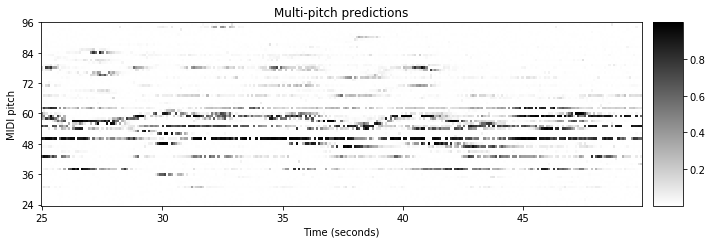

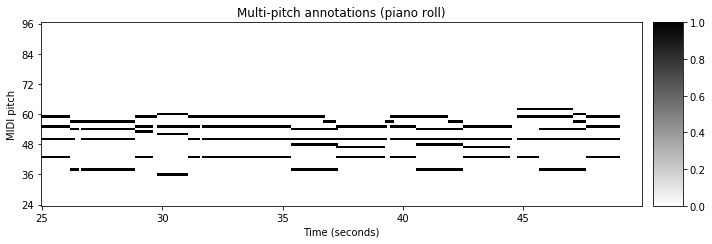

In [5]:
start_sec = 25
show_sec = 50

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 3.5))
im = libfmp.b.plot_matrix(predictions.T[:, int(start_sec*fs_hcqt):int(show_sec*fs_hcqt)], Fs=fs_hcqt, ax=ax, cmap='gray_r', ylabel='MIDI pitch')
ax[0].set_yticks(np.arange(0, 73, 12))
ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+1)])
ax[0].set_title('Multi-pitch predictions')
ax[0].set_xticklabels(np.arange(start_sec-5, show_sec+5, 5))
ax[1].set_ylim([0, 1])
plt.tight_layout()


annot_folder = os.path.join(basepath, 'data', 'Schubert_Winterreise', 'ann_audio_note')
fn_annot = os.path.join(annot_folder, fn_audio[:-4]+'.csv')

df = pd.read_csv(fn_annot, sep=';', skiprows=1, header=None)
note_events = df.to_numpy()[:, :3]
        
f_annot_pitch = compute_annotation_array_nooverlap(note_events.copy(), f_hcqt, fs_hcqt, annot_type='pitch', shorten=1.0)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 3.5))
cfig, cax, cim = libfmp.b.plot_matrix(f_annot_pitch[24:97, int(start_sec*fs_hcqt):int(show_sec*fs_hcqt)], ax=ax, Fs=fs_hcqt, cmap='gray_r', ylabel='MIDI pitch')
plt.ylim([0, 73])
ax[0].set_yticks(np.arange(0, 73, 12))
ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+1)])
ax[0].set_title('Multi-pitch annotations (piano roll)')
ax[0].set_xticklabels(np.arange(start_sec-5, show_sec+5, 5))
ax[1].set_ylim([0, 1])
plt.tight_layout()